<a href="https://colab.research.google.com/github/Sompote/PIle/blob/main/pile_transformer_MAR_27_ipynb_completed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install -q tensorflow #install nlp for keras

In [29]:

#Transformer Autoencoder to predict RIC combind model by Dr. Sompote Youwai 2023
import numpy as np
import pandas as pd

# Import libraries
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd

file_name='/content/pile_test_mar_28.xlsx'

df = pd.read_excel(file_name,sheet_name='soil')
df_y = pd.read_excel(file_name,sheet_name='pile')
df_p = pd.read_excel(file_name,sheet_name='pile_length')


data=np.array(df)
data_y=np.array(df_y)
data_pile=np.array(df_p)
data_pile=data_pile[:,1:21]

#X=data[:,1:29]
#Y=data[:,34:62]
x_feature=data_y[:,41:45]
Y=data_y[:,1:41]

bh=data[:,1:21]
bh2=data[:,21:122]/2
mask = (Y != -1)
#Y=np.ma.masked_where(mask, Y)


#scale data
X_train=bh
Y_train=Y
sc_y=MinMaxScaler()
sc = MinMaxScaler()
sc_f=MinMaxScaler()

X_feature=x_feature

x_train=X_train/50 #normalize
#x_train = sc.fit_transform(X_train)
#y_train=sc_y.fit_transform(Y_train,axis=1)

y_train=Y_train/40000
x_feature=sc_f.fit_transform(X_feature)
#x_train=X_train
#y_train=Y_train
train = np.where(mask, y_train, -1)


soil_data=np.stack([x_train,bh2,data_pile],axis=2)

X=soil_data



#preparing input matrix
#first dim is time step, 2-4 is feature
X_train_CNN=np.zeros((X.shape[0],X.shape[1],X_feature.shape[1]+3))
X_train_CNN[:,:,0:3]=X
for i in range(0,(X.shape[0])):
  X_train_CNN[i,:,3]=x_feature[i,1]
  X_train_CNN[i,:,4]=x_feature[i,2]
  X_train_CNN[i,:,5]=x_feature[i,3]
  X_train_CNN[i,:,6]=x_feature[i,3]

#X_train_CNN=soil_data

check=x_train

#preparing data for training each time step for each Y data using concept seq2seq
def encoder_f(x_f,time_step): #feature encoder same feature in each sample
  shape=x_f.shape
  x=x_f
  step=time_step
  x_sum_t=x[0:1,:]
  for time in range(1,time_step):
    x_sum=x[0:1,:]
    x_sum_t=np.append(x_sum_t,x_sum,axis=0)
  sum_X=x_sum_t

  for sample in range(1,shape[0]):
    x_sum_ts=x[sample:sample+1,:]

    for time in range(1,time_step):
        x_sum=x[sample:sample+1,:]
        #x_sum=np.reshape(x_sum,(1,x_sum.shape[0],x_sum.shape[1]))


        x_sum_ts=np.append(x_sum_ts,x_sum,axis=0)

    sum_X=np.append(sum_X,x_sum_ts,axis=0)
  return sum_X

#prepare x in encoder #enter CNN and use similar encode for  smaple in diffrent time step
def encoder_x(x_cnn,y_train):
  shape=y_train.shape
  x=x_cnn

  x_sum_t=x[0:1,:,:]
  for time in range(1,shape[1]):
    x_sum=x[0:1,:,:]
    x_sum=np.reshape(x_sum,(1,x_sum.shape[1],x_sum.shape[2]))
    x_sum_t=np.append(x_sum_t,x_sum,axis=0)

  sum_X=x_sum_t

  for sample in range(1,shape[0]):
    x_sum_ts=x[sample:sample+1,:,:]

    for time in range(1,shape[1]):
        x_sum=x[sample,:,:]
        x_sum=np.reshape(x_sum,(1,x_sum.shape[0],x_sum.shape[1]))
        x_sum_ts=np.append(x_sum_ts,x_sum,axis=0)

    sum_X=np.append(sum_X,x_sum_ts,axis=0)
  return sum_X

def padding(x_pad,shift=1): #padding time shift right -shift right =1
  xt=x_pad
  if (shift>0):
    ap=np.zeros((xt.shape[0],shift))
    xt=np.concatenate((ap,xt), axis=1)
  xt_1 = xt[0,0:1]
  xt_p1=  np.pad(xt_1, (0, xt.shape[1]-1), mode='constant')
  x_sum=xt_p1
  for i in range(1,x_train.shape[1]):
    xt_t = xt[0,0:i+1]
    xt_pt=  np.pad(xt_t, (0, xt.shape[1]-xt_t.shape[0]), mode='constant')

    x_sum=np.vstack((x_sum, xt_pt))
  return x_sum

#padding time shift right -shift right =1 prepare the squence for decoder usinhe previous time step
def padding_full(x_pad,shift=1):
  xt=x_pad
  if (shift>0):
    ap=np.zeros((xt.shape[0],shift))
    xt=np.concatenate((ap,xt), axis=1)

  xt_1 = xt[0,0:1]
  xt_p1=  np.pad(xt_1, (0, xt.shape[1]-1), mode='constant')
  x_sum=xt_p1
  for i in range(1,y_train.shape[1]):
    xt_t = xt[0,0:i+1]
    xt_pt=  np.pad(xt_t, (0, xt.shape[1]-xt_t.shape[0]), mode='constant')

    x_sum=np.vstack((x_sum, xt_pt))
  x_sum_train=x_sum

  for num_s in range(1,xt.shape[0]):
    xt_1 = xt[num_s,0:1]
    xt_p1=  np.pad(xt_1, (0, xt.shape[1]-1), mode='constant')
    x_sum=xt_p1
    for i in range(1,y_train.shape[1]):
      xt_t = xt[num_s,0:i+1]
      xt_pt=  np.pad(xt_t, (0, xt.shape[1]-xt_t.shape[0]), mode='constant')

      x_sum=np.vstack((x_sum, xt_pt))
    x_sum_train =np.vstack((x_sum_train, x_sum))

  return x_sum_train


def out_put(y_train): #prepare y_value each step
  y_t=y_train

  y_sum=y_t[0,0]

  for time in range(1,y_t.shape[1]):
    y_sum=np.vstack((y_sum,y_t[0,time]))
  ysum_t=y_sum

  for nums in range(1,y_t.shape[0]):
    y_sum=y_t[nums,0]
    for time in range(1,y_t.shape[1]):
      y_sum=np.vstack((y_sum,y_t[nums,time]))

    ysum_t=np.vstack((y_sum,ysum_t))
  return ysum_t
def out_put2(y_train):
  dummy=y_train.T
  shape=dummy.shape
  out=dummy[:,0]
  for dim_x in range(1,dummy.shape[1]):
    out=np.hstack((out,dummy[:,dim_x]))
  out=np.reshape(out,(out.shape[0],1))
  return out

def padding_full2(x_pad,shift=1):
  xt=x_pad
  if (shift>0):
    ap=np.zeros((xt.shape[0],shift))
    xt=np.concatenate((ap,xt), axis=1)

  xt_1 = xt[0,0:1]
  xt_p1=  np.pad(xt_1, (0, xt.shape[1]-1), mode='constant')
  x_sum=xt_p1
  for i in range(1,x_train.shape[1]):
    xt_t = xt[0,0:i+1]
    xt_pt=  np.pad(xt_t, (0, xt.shape[1]-xt_t.shape[0]), mode='constant')

    x_sum=np.vstack((x_sum, xt_pt))
  x_sum_train=x_sum

  for num_s in range(1,xt.shape[0]):
    xt_1 = xt[num_s,0:1]
    xt_p1=  np.pad(xt_1, (0, xt.shape[1]-1), mode='constant')
    x_sum=xt_p1
    for i in range(1,x_train.shape[1]):
      xt_t = xt[num_s,0:i+1]
      xt_pt=  np.pad(xt_t, (0, xt.shape[1]-xt_t.shape[0]), mode='constant')

      x_sum=np.vstack((x_sum, xt_pt))
    x_sum_train =np.vstack((x_sum_train, x_sum))

  return x_sum_train

time_step=40
x_f=encoder_f(x_feature,time_step)
x_train_encoder=encoder_x(X_train_CNN,y_train)
y_decode=padding_full(x_pad=y_train, shift=1)
y_decode = np.delete (y_decode, -1, axis=1)
y_train1=out_put2(y_train)


#drop data that the result is mnot available
drop=np.where(y_train1 < 0) #remove pad data
y_train1 = np.delete (y_train1, drop,axis=0)
y_decode= np.delete (y_decode, drop,axis=0)
x_train_encoder= np.delete (x_train_encoder, drop,axis=0)
x_f= np.delete (x_f, drop,axis=0)



#split data
X_train, X_test, X_feature_train, X_feature_test, Y_train, Y_test, y_d_train,y_d_test = train_test_split(x_train_encoder, x_f, y_train1, y_decode,random_state=1,test_size=0.05)


# New Section

In [2]:
X_train.shape

(166, 20, 7)

In [ ]:
y_decode[0]

array([0.     , 0.03405, 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     ])

In [30]:
#Model generation part
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, Flatten, concatenate,Reshape, Dropout,Bidirectional,LayerNormalization
from keras.layers import MaxPooling1D
from keras.layers import LSTM, Dense
from keras.metrics import MeanAbsolutePercentageError
from keras import *
from keras.optimizers import  Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
#from attention import Attention




def transformer_encoder(inputs, head_size, num_heads, ff_dim,
                        dropout=0.1, attention_axes=None,lmask=None):
  """
  Creates a single transformer block.

  """
  x=inputs
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x,attention_mask=lmask)

  x = layers.Dropout(dropout)(x)
  res = x + inputs

  '''   # Feed Forward Part
  x = layers.LayerNormalization(epsilon=1e-6)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)'''
  x = layers.LayerNormalization(epsilon=1e-6)(x)

  return x+res


def transformer_encodercross(input1, input2,head_size, num_heads, ff_dim,
                        dropout=0, attention_axes=None):

  #Creates a single transformer block.


  y=input2


  x=input1


  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x,y)


  x = layers.Dropout(dropout)(x)
  res=x + input1
  res = layers.LayerNormalization(epsilon=1e-6)(res)
  return res


def CNN_model(cnn_input_shape):
  # Create the CNN model
  cnn_input = Input(shape=cnn_input_shape,name='CNN_input')
  #x = keras_nlp.layers.PositionEmbedding(sequence_length=time_step)(cnn_input)
  x=cnn_input

  for i in range(10):
    x=transformer_encoder(x, head_size=10, num_heads=60, ff_dim=3,dropout=0.1,attention_axes=1)

  x = Flatten()(x)
  x = Dense(50, activation='linear')(x)
  cnn_model = Model(inputs=cnn_input, outputs=x,name='CNN_model')
  return cnn_model




def decoding_model_transformer(latent_dim,time_step):
  masking_layer = layers.Masking(mask_value=0)
  inputs_f = Input(shape=(feature_dim,), name='feature')
  layerfeature=  Dense(50, activation='sigmoid')(inputs_f)

  inputs_l = Input(shape=(50,), name='latent') #from decoder


  input_lag=Input(shape=(output_shift_shape,), name='lag_input')
  x=input_lag

  masked_inputs = masking_layer(input_lag)
  mask = masked_inputs[:, tf.newaxis, :]

  print(masked_inputs)
  #x = keras_nlp.layers.PositionEmbedding(sequence_length=time_step)(x)
  #x = layers.LayerNormalization(epsilon=1e-6)(input)

  for i in range(10):
    x=transformer_encoder(x, head_size=3, num_heads=60, ff_dim=3,dropout=0.1, attention_axes=1)
  x=Flatten()(x)
  x=Dense(50,activation='sigmoid')(x)
  print(x)
  print(inputs_l)
  com=concatenate([x,inputs_l,layerfeature])

  print(com)
  x = Flatten()(com)
  layer = Dense(50, activation='linear')(x)

  layer=Dropout(0.1)(layer)
  layer=Dense(200, activation='sigmoid')(layer)
  layer=Dense(100, activation='sigmoid')(layer)
  layer=Dense(50, activation='sigmoid')(layer)
  layer=Dense(5, activation='sigmoid')(layer)

  dense_output = Dense(1, activation='linear')(layer)
  output=dense_output
  model = Model([inputs_l,input_lag,inputs_f], outputs=output,name='decoding_model')
  return model



def transformer(encoding_model,decoding_model):
  input_lag=Input(shape=(None,1), name='lag_input')
  inputs_f = Input(shape=(feature_dim,), name='feature')

  inputs_l=encoding_model.output
  outputs = decoding_model([inputs_l,input_lag,inputs_f])
  model = Model(inputs=[encoding_model.input,input_lag,inputs_f], outputs=outputs,name='Transformer')
  return model



# Compile and summarize the combined model
#Main program

dense_input_shape = (X_train.shape[1])
cnn_input_shape = (X_train.shape[1],X_train.shape[2])
LSTM_input_shape=(X_train.shape[1])
output_shift_shape=y_d_train.shape[1]
feature_dim=X_feature.shape[1]

latent_dim=16
time_step=X_train.shape[1]
model_cnn=CNN_model(cnn_input_shape)
model_decoding_transformer=decoding_model_transformer(latent_dim,time_step)

model_transform=transformer(model_cnn,model_decoding_transformer)

opti=optimizers.Adam(
    learning_rate=0.0001,beta_1=0.9,beta_2=0.999,epsilon=1e-07,name="Adam"
)


model_transform.compile(optimizer=opti, loss='mse', metrics=['mae','mape'])
model_transform.summary()


#from tensorflow.keras.callbacks import ModelCheckpoint
#checkpoint = ModelCheckpoint('model_best_weights.keras', monitor='loss', save_best_only=True)


# Define a callback to save the model if the loss does not change for 5 epochs
checkpoint = ModelCheckpoint('pile_minmax_26_sept.keras', save_best_only=True, monitor='loss', mode='min', verbose=2)
early_stopping = EarlyStopping(monitor='loss', mode='min', patience=7, verbose=2)

# Train the model

history=model_transform.fit([X_train,y_d_train,X_feature_train],
                            Y_train, epochs=5000, batch_size=50,validation_data=([X_test,y_d_test,X_feature_test], Y_test),verbose=2)
#callbacks=checkpoint
model_transform.save('transformer_1Nov.keras')

Streaming output truncated to the last 5000 lines.
Epoch 2501/5000
4/4 - 0s - loss: 1.7282e-06 - mae: 0.0010 - mape: 9.6323 - val_loss: 4.2981e-06 - val_mae: 0.0013 - val_mape: 11.6127 - 210ms/epoch - 53ms/step
Epoch 2502/5000
4/4 - 0s - loss: 1.9310e-06 - mae: 0.0011 - mape: 10.9104 - val_loss: 4.7406e-06 - val_mae: 0.0014 - val_mape: 12.0143 - 206ms/epoch - 52ms/step
Epoch 2503/5000
4/4 - 0s - loss: 1.8171e-06 - mae: 0.0010 - mape: 9.6253 - val_loss: 4.6832e-06 - val_mae: 0.0012 - val_mape: 11.0767 - 232ms/epoch - 58ms/step
Epoch 2504/5000
4/4 - 0s - loss: 1.9083e-06 - mae: 0.0010 - mape: 9.5678 - val_loss: 8.7534e-06 - val_mae: 0.0016 - val_mape: 15.2520 - 232ms/epoch - 58ms/step
Epoch 2505/5000
4/4 - 0s - loss: 2.3551e-06 - mae: 0.0011 - mape: 10.0483 - val_loss: 6.9488e-06 - val_mae: 0.0016 - val_mape: 13.0239 - 221ms/epoch - 55ms/step
Epoch 2506/5000
4/4 - 0s - loss: 1.9058e-06 - mae: 0.0010 - mape: 9.1639 - val_loss: 4.3957e-06 - val_mae: 0.0013 - val_mape: 12.0066 - 206ms/epoch

In [ ]:
model_transform.save('transformer_6_oct.keras')

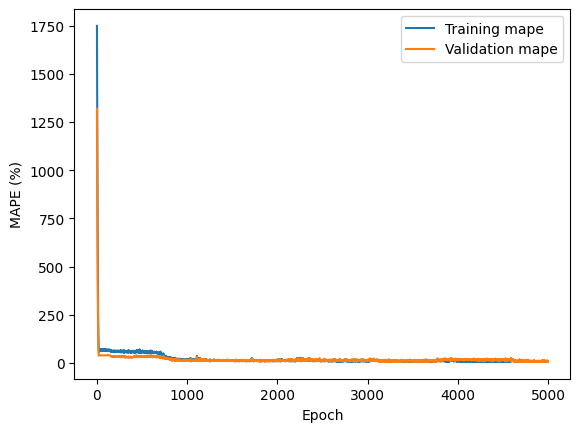

In [31]:
# Plot training and validation loss
plt.plot(history.history['mape'], label='Training mape')
plt.plot(history.history['val_mape'], label='Validation mape')
plt.xlabel('Epoch')
plt.ylabel('MAPE (%)')
plt.legend()
plt.show()

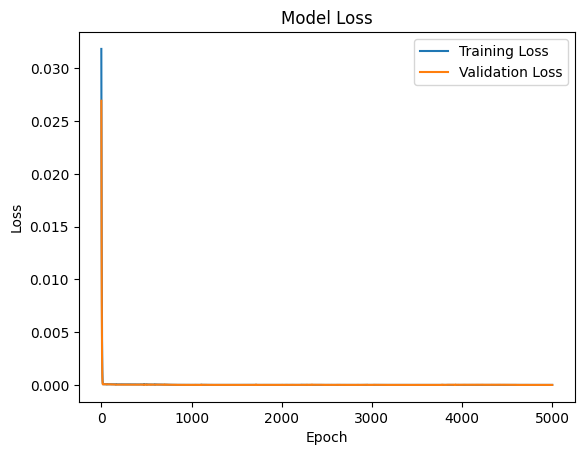

In [32]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
output_shift_shape

40

In [ ]:
cnn_input_shape

(20, 7)

In [ ]:
y_d_train

array([[0.      , 0.0029  , 0.004925, ..., 0.      , 0.      , 0.      ],
       [0.      , 0.001525, 0.00255 , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.001525, 0.00255 , ..., 0.      , 0.      , 0.      ],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.00245 , 0.004225, ..., 0.      , 0.      , 0.      ],
       [0.      , 0.001525, 0.00255 , ..., 0.      , 0.      , 0.      ]])

In [ ]:
feature_dim

4

In [ ]:
model_transform.save('transformer_mile.keras')

In [ ]:
import pickle

pickle.dump(sc_f, open('scaler_f_min.pkl', 'wb'))

## **PREDICT - START**

In [33]:
#Transformer prediciton to predict RIC combind model by Dr. Sompote Youwai 2023
import numpy as np
import pandas as pd

# Import libraries
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd

#import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, Flatten, concatenate,Reshape, Dropout,Bidirectional,LayerNormalization
from keras.layers import MaxPooling1D
from keras.layers import LSTM, Dense
from keras.metrics import MeanAbsolutePercentageError
from keras import *
from keras.optimizers import Adam
#import keras_nlp


df = pd.read_excel(file_name,sheet_name='soil')
df_y = pd.read_excel(file_name,sheet_name='pile')
df_p = pd.read_excel(file_name,sheet_name='pile_length')


data=np.array(df)
data_y=np.array(df_y)
data_pile=np.array(df_p)
data_pile=data_pile[:,1:21]

#X=data[:,1:29]
#Y=data[:,34:62]
x_feature=data_y[:,41:45]
Y=data_y[:,1:41]

bh=data[:,1:21]
bh2=data[:,21:122]/2
mask = (Y != -1)
#Y=np.ma.masked_where(mask, Y)
#Y=np.ma.masked_where(mask, Y)
#Y=np.ma.masked_where(mask, Y)


#scale data
X_train=bh
Y_train=Y

import pickle #download weight scaler
import pickle #download weight scaler
#sc = pickle.load(open('scaler_x_min.pkl', 'rb'))
#sc_y = pickle.load(open('scaler_n_y_min.pkl','rb'))
#sc_f = pickle.load(open('scaler_f_min.pkl', 'rb'))

X_feature=x_feature

#x_train = sc.transform(X_train)
x_train=X_train/50
#y_train=sc_y.transform(Y_train)
y_train=Y_train/40000
x_feature=sc_f.transform(X_feature)

train = np.where(mask, y_train, -1)


soil_data=np.stack([x_train,bh2,data_pile],axis=2)

X=soil_data



#preparing input matrix
#first dim is time step, 2-4 is feature
X_train_CNN=np.zeros((X.shape[0],X.shape[1],X_feature.shape[1]+3))
X_train_CNN[:,:,0:3]=X
for i in range(0,(X.shape[0])):
  X_train_CNN[i,:,3]=x_feature[i,1]
  X_train_CNN[i,:,4]=x_feature[i,2]
  X_train_CNN[i,:,5]=x_feature[i,3]
  X_train_CNN[i,:,6]=x_feature[i,3]


check=x_train

XT=X_train_CNN
Y=y_train
X_feature=x_feature

In [34]:
# transformer = models.load_model('transformer_mile.keras')
transformer = model_transform

In [35]:
#prediciton of the specify number of pile
#prepare data
#feature=np.reshape(feature,(1,-1))
sample=8 #pile number that want to predict
Xd=XT[sample-1:sample]
Yd=Y[sample-1:sample]
fd=X_feature[sample-1:sample]
Yd_nonscale=Yd
#feature=x_featured[sample-1:sample]
#feature=np.array([50,10,3])

#Xdd = sc.transform(Xd)
#Yd=sc_y.transform(Yd)
#fd_s=sc_f.transform(fd)
y_ini=np.zeros((1,40))
y_ini[0,0]=0
x_train=Xd
#y_ini=scaler_y.transform(y_ini)




In [9]:
transformer.summary()

Model: "Transformer"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 CNN_input (InputLayer)      [(None, 20, 7)]              0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, 20, 7)                18607     ['CNN_input[0][0]',           
 iHeadAttention)                                                     'CNN_input[0][0]']           
                                                                                                  
 dropout (Dropout)           (None, 20, 7)                0         ['multi_head_attention[0][0]']
                                                                                                  
 layer_normalization (Layer  (None, 20, 7)                14        ['dropout[0][0]']   

1/1 [==============================] - 0s 25ms/step


<ipython-input-36-b726caf56fd5>:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_ini[0,step+1]=y


1/1 [==============================] - 0s 25ms/step
-11113021.587229352


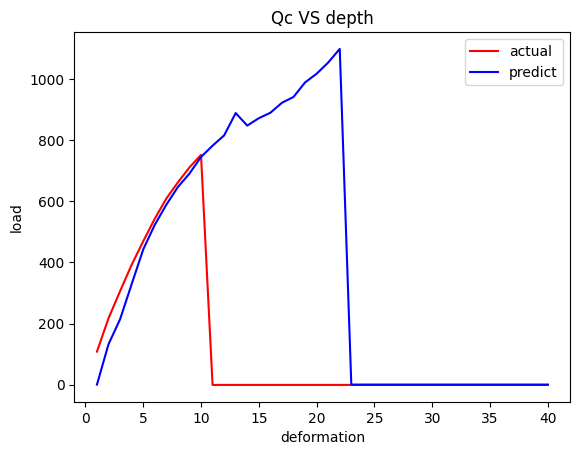

In [36]:

#prediciton of the specify number of pile

for step in range(0,21):
  y=transformer.predict([x_train,y_ini,fd])
  y_ini[0,step+1]=y

# y_ini[0,0] = transformer.predict([x_train,y_ini,fd])

#y_pred=sc_y.inverse_transform(y_ini)
y_pred=y_ini*40000

import matplotlib.pyplot as plt
def mape(x,y):
  error=np.abs(x-y)/x
  mape=np.mean(error)
  return mape

# Define the x-axis and corresponding y-axis values as lists

ydist=range(1,41)

# Plot them on canvas using plt.plot() function
plt.plot( ydist,Y_train[sample-1],color='red',label='actual')
plt.plot( ydist,y_pred[0],color='blue',label='predict')
plt.legend()
print(mape(Y[sample-1],y_pred[0]))

# Give a name to x-axis and y-axis using plt.xlabel() and plt.ylabel() functions
plt.xlabel("deformation")
plt.ylabel("load")

# Give a title to your plot using plt.title() function
plt.title("Qc VS depth")
# Get the current axes instance
ax = plt.gca()

# Invert the y-axis
#ax.invert_yaxis()

# Finally, to view your plot, we use plt.show() function
plt.show()


<ipython-input-38-4c2016a94916>:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_ini[0,step+1]=y


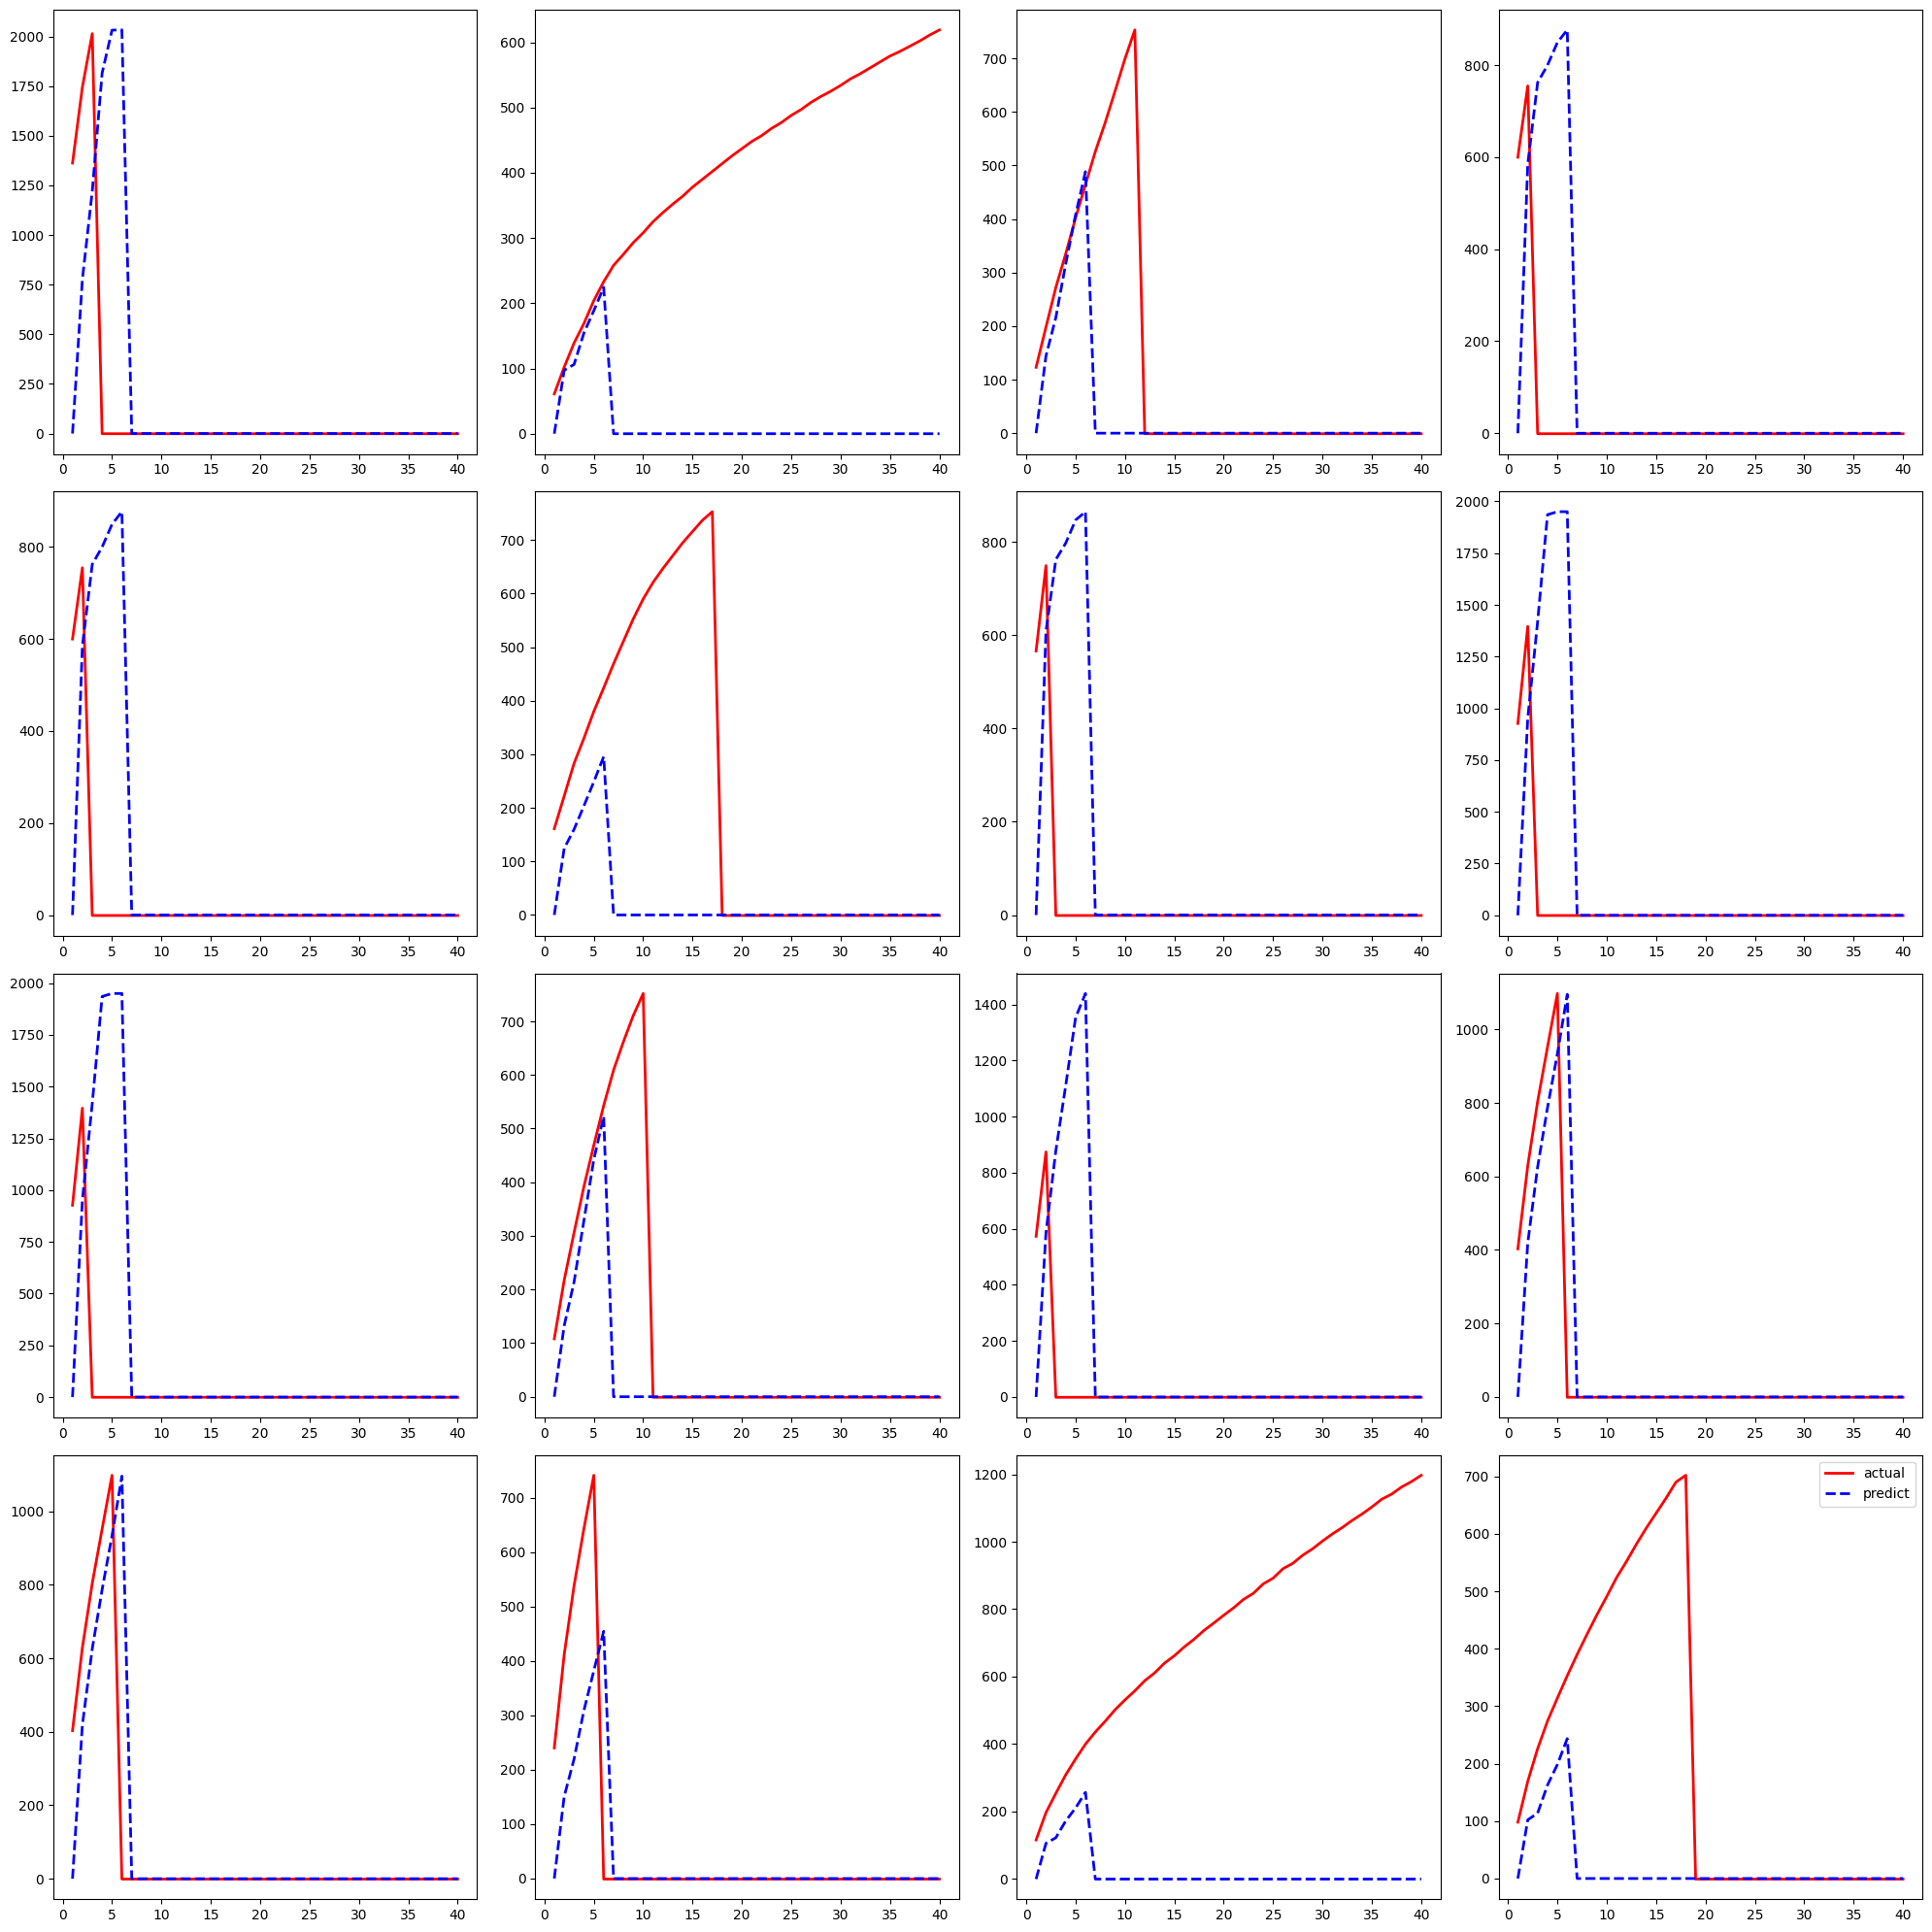

In [38]:
#prediciton all pile

import matplotlib.pyplot as plt

def predict(n):
    #prepare data
    #feature=np.reshape(feature,(1,-1))
    sample=n
    Xd=XT[sample-1:sample]
    Yd=Y[sample-1:sample]
    fd=X_feature[sample-1:sample]
    Yd_nonscale=Yd
    #feature=x_featured[sample-1:sample]
    #feature=np.array([50,10,3])

    #Xdd = sc.transform(Xd)
    #Yd=sc_y.transform(Yd)
    #fd_s=sc_f.transform(fd)
    y_ini=np.zeros((1,40))
    y_ini[0,0]=0
    x_train=Xd
    for step in range(0,5):
      y=transformer.predict([x_train,y_ini,fd],verbose=0)
      y_ini[0,step+1]=y

    #y_pred=sc_y.inverse_transform(y_ini)
    y_pred=y_ini*40000
    return y_pred


ydist=range(1,41)

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
n= 0 #itial point
# Loop over the subplots and plot the data 40
for i in range(0,4):
    for j in range(0,4):

        y_pred=predict(n+3*i+j+1)
        ax[i, j].plot( ydist,Y_train[n+3*i+j],color='red',label='actual',linewidth=2)
        ax[i, j].plot( ydist,y_pred[0],color='blue',
                      label='predict',linewidth=2,linestyle='--')

plt.tight_layout()
plt.legend()
plt.show()

# Show the figure
